In [3]:
import fitz  # Import the PyMuPDF library
import pandas as pd
pd.set_option('mode.copy_on_write', True)
import re
import os
import glob
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import Matcher
lemmatizer = nlp.get_pipe("lemmatizer")
import datetime
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import json
import numpy as np
import seaborn as sns
    from kneed import KneeLocator
import matplotlib.pyplot as plt

In [4]:
current_datetime = datetime.datetime.now()

In [5]:
#Import literature and store for pre-processing
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Expert_Corpus/"
lit_docs = pd.read_csv(path + 'Bibliography.csv') #Bibilography of policy docs and their perspective 

df_lit_docs = pd.DataFrame(columns = ['Document', 'Raw Text', 'Perspective'])

def extract_text_from_pdf(pdf_doc):
    text = ""
    # Open the PDF file
    with fitz.open(pdf_doc) as pdf_document:
        # Iterate over each page in the PDF
        for page_number in range(len(pdf_document)):
            # Get the page object
            page = pdf_document.load_page(page_number)
            # Extract text from the page
            text += page.get_text()
    return text

for index, row in lit_docs.iterrows():
    pdf_doc = path + str(row['Document'])
    text = extract_text_from_pdf(pdf_doc)

    # Append the text to the DataFrame
    new_row = {'Document': str(row['Document']), 'Raw Text': text, 'Perspective': str(row['Perspective'])}
    df_lit_docs.loc[len(df_lit_docs)] = new_row

In [6]:
#Download lit. for use in the corresponding code when we compare with Civil Service Vacancies
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Expert_Corpus/Consolidated/"

df_lit_docs.to_csv(path + 'consolidated_lit' + str(current_datetime) + '.csv', index=True)

In [7]:
#Convert text to list 
lit_corpus = []
lit_corpus_text = df_lit_docs['Raw Text'].tolist()

#Capture the document perspectives for use later
perspectives_unique = df_lit_docs['Perspective'].unique()
list_perspectives= []

for item in perspectives_unique:
    count = (df_lit_docs['Perspective'] == item).sum()  
    list_perspectives.extend([item] * count)

In [8]:
#Just for info. count the number of words in the corpuses being processed
total_words = 0

for item in lit_corpus_text:
    words = item.split()
    total_words += len(words)

print(f"Total number of words in the corpus is: {total_words}")

#For info. count the number of documents in each perspective
print(df_lit_docs.groupby('Perspective').size())

Total number of words in the corpus is: 1117037
Perspective
design_and_innovation               7
interviews                          9
making_interdisciplinarity_work    11
making_the_case                    13
reflection                         15
dtype: int64


In [9]:
# Initialize the Matcher with the patterns
file_path_patterns = file_path = '/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Patterns/patterns_skills.json'

# Load JSON file containing patterns
with open(file_path_patterns, "r") as json_file:
    patterns_data = json.load(json_file)

# Create a Matcher object
matcher = Matcher(nlp.vocab)

for pattern_entry in patterns_data:
    label = pattern_entry.get("label")
    pattern = pattern_entry.get("pattern")
    matcher.add(label, [pattern])

In [10]:
#Run Tf-IDF

#Store for manual check in order to improve patterns
list_sentence=[]
list_NP_original=[]
list_NP_surface_form=[]

chunk_size = 100_000  #For batch processing

def custom_tokenizer(long_text):
    # Process the text in chunks
    chunks = [long_text[i:i+chunk_size] for i in range(0, len(long_text), chunk_size)]
    docs = [nlp(chunk) for chunk in chunks]

    for doc in docs:
        return_NP_surface_form=[]
        matches = matcher(doc)
        for match_id, match_start, match_end in matches: # Note, there can be 2+ matches in a sentence 
            for sent in doc.sents:  #Store the source sentence
                if match_start >= sent.start and match_end <= sent.end:
                    sent_to_store = sent      
            list_sentence.append(sent_to_store) #This is the original whole sentence
            #Store the matched phrase
            noun_phrase = doc[match_start:match_end]
            list_NP_original.append(noun_phrase) #Capture the original noun-phrase
            #Build-up and store the corresponding Lemma
            lemmatized_NP = ' '.join(token.lemma_ for token in noun_phrase)
            list_NP_surface_form.append(lemmatized_NP)
            return_NP_surface_form.append(lemmatized_NP)

        return(return_NP_surface_form)

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, input = 'content', strip_accents = 'ascii', stop_words = 'english', max_features=400, use_idf=True)
tfidf_matrix_lit_corpus = tfidf.fit_transform(lit_corpus_text)

#Use L2 Normalisation
tfidf_matrix_l2 = normalize(tfidf_matrix_lit_corpus, norm='l2')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
#Present overall Tf-IDF results
#Convert to dense matrices
dense_matrix_tfidf = tfidf_matrix_l2.todense().tolist() 
#Get feature names
feature_names_lit = tfidf.get_feature_names_out()
#Get index values
#list_perspectives = df_lit_corpus_grouped['Perspective'].to_list() 

df_tfidf_results_ungrouped = pd.DataFrame(dense_matrix_tfidf,columns=feature_names_lit)
df_tfidf_results_ungrouped.index = list_perspectives

#Store results
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"

df_tfidf_results_ungrouped.to_csv(path + 'Skill_Phrases_All' + str(current_datetime) + '.csv', index=True)

In [10]:
#Build-up results for manual check and pattern refinement
list_features=[]
list_np_surface_forms=[]
list_np_original=[]
list_sent=[]

#Remove duplicate sentences from the sentence list
unique_sentences = list(set(list_sentence))

for feature in feature_names_lit:
    try:    
        index = list_NP_surface_form.index(feature)
        surface_form = list_NP_surface_form[index]
        np_original = list_NP_original[index].text
        for sent in unique_sentences:
            if np_original in sent.text.strip().lower():
                list_features.append(feature)
                list_np_surface_forms.append(surface_form)
                list_np_original.append(np_original)
                list_sent.append(sent.text)
    except:
        continue

df_manual_review  = pd.DataFrame({ 
                                    'Feature': list_features,
                                    'Surface Form': list_np_surface_forms,
                                    'Original Noun Phrase': list_np_original,
                                    'Sentences': list_sent
                                    })


df_manual_review.sort_values(by='Feature', ascending=False, inplace=True)

df_manual_review.to_csv(path + 'Manual_Review_Skills_ID_' + str(current_datetime) + '.csv', index=True)

In [12]:
#Create a dictionary object from the skill groups manually identified and mapped
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Skill Groupings/"

skill_mapping = pd.read_excel(path + "skill_groupings.xlsx")

dict_skill_groupings = {}

#Build-up the dictionary
for index, row in skill_mapping.iterrows():
    key = row['Key']
    value = row['Values']
   
    if key in dict_skill_groupings:
        dict_skill_groupings[key].append(value)
    else:
        dict_skill_groupings[key] = [value]

In [13]:
#Group Tf-IDF features by higher level skill and calculate the mean tfidf scores -  i. by perspective ii. across all documents

perspective=[]
feature=[]
mapped_skill=[]
tfidf_results=[]

for col_name, col_data in df_tfidf_results_ungrouped.items():
    index_data = col_data.index #This is the document category - e.g., design and innovation
    perspective.extend(index_data)
    feature.extend([col_name] * len(col_data.values)) #Hold the unmapped feature
    tfidf_results.extend(col_data.values)

#Get at the higher-level skill
    match = False
    for key, value in dict_skill_groupings.items():
        if col_name in value:
            mapped_skill.extend([key] * len(col_data.values))
            match = True
            break
        else:
            continue
    if match != True:
        print(f"unmatched value is: {col_name}")
        mapped_skill.extend(['Not Mapped'] * len(col_data.values))

#Store as a DataFrame
data = {'perspective': perspective,
        'feature': feature,
        'mapped skill': mapped_skill,
        'tf_idf': tfidf_results
        }

df_tfidf_mapped = pd.DataFrame(data)

df_tfidf_mapped.drop('feature', axis=1, inplace=True)

#Calc. mean TFIDF by perspective and higher-level skill
df_tfidf_grouped_by_perspective = df_tfidf_mapped.groupby(['perspective', 'mapped skill']).mean()

#Calc. mean by higher-level skill only
df_tfidf_mapped.drop('perspective', axis=1, inplace=True)
df_tfidf_grouped_by_higher_skills = df_tfidf_mapped.groupby(['mapped skill']).mean()

unmatched value is: advocate innovation


In [14]:
#If desired only - store results
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
current_datetime = datetime.datetime.now()

df_tfidf_grouped_by_perspective.to_csv(path + 'tfidf_mean_by_perspective' + str(current_datetime) + '.csv', index=True)
df_tfidf_grouped_by_higher_skills.to_csv(path + 'tfidf_mean_by_higher_skill' + str(current_datetime) + '.csv', index=True)

In [15]:
df_tfidf_grouped_by_perspective.reset_index(inplace=True)
df_tfidf_grouped_by_higher_skills.reset_index(inplace=True)

In [16]:
#Manual intervention - remove higher-level skills groupings that lack specificity
skills_to_remove = ['Mission Governance',
                    'Mission Delivery',
                    'Mission Design',
                    'Mission Support']

df_tfidf_grouped_by_perspective = df_tfidf_grouped_by_perspective[~df_tfidf_grouped_by_perspective['mapped skill'].isin(skills_to_remove)]
df_tfidf_grouped_by_higher_skills = df_tfidf_grouped_by_higher_skills[~df_tfidf_grouped_by_higher_skills['mapped skill'].isin(skills_to_remove)]


Elbow point is at index: 16


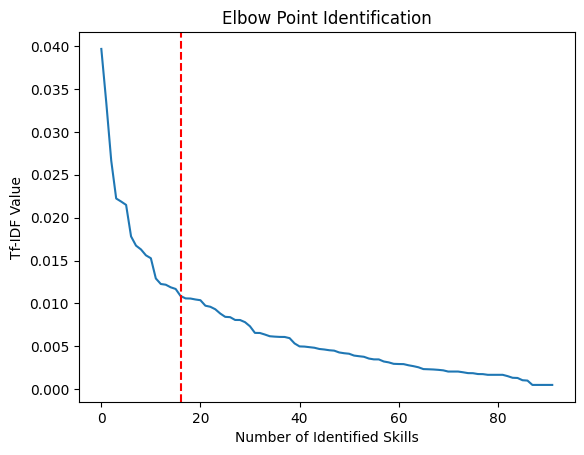

In [23]:
#Identify the most important skills - calculate n based on elbow point

# Sort values in descending order
sorted_skills = df_tfidf_grouped_by_higher_skills['tf_idf'].sort_values(ascending=False).reset_index(drop=True)

#Find and graph the elbow point
knee_locator = KneeLocator(range(len(sorted_skills)), sorted_skills, curve='convex', direction='decreasing', S=2.0)
elbow_point = knee_locator.elbow

plt.plot(sorted_skills)

plt.axvline(x=elbow_point, color='r', linestyle='--')
print(f'Elbow point is at index: {elbow_point}')

plt.xlabel('Number of Identified Skills')
plt.ylabel('Tf-IDF Value')
plt.title('Elbow Point Identification')
plt.show()

top_n = elbow_point

In [18]:
#Retrieve the most important skills
top_indices = df_tfidf_grouped_by_higher_skills['tf_idf'].nlargest(top_n).index
df_top_tfidf_across_perspectives = df_tfidf_grouped_by_higher_skills.loc[top_indices, ['mapped skill', 'tf_idf']]

#Store as a list for subsequent use alongside Civil Service vacancies
df_skills_for_tracking = df_top_tfidf_across_perspectives['mapped skill']

path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
current_datetime = datetime.datetime.now()

df_skills_for_tracking.to_csv(path + 'Skills_for_tracking' + str(current_datetime) + '.csv', index=True)

In [19]:
print(df_skills_for_tracking)

32                  Experimentation
17                       Creativity
56         Participatory Approaches
34                        Foresight
11                        Co-design
95       Working across disciplines
3                           Agility
39             Influence Innovation
76                        Set Focus
88                       Take Risks
2                      Adaptability
51                     Mobilisation
24                  Design Thinking
60    Portfolio Design / Management
86                   System Mapping
10               Citizen Engagement
Name: mapped skill, dtype: object


In [20]:
#Count the number of perspectives that a skill appears in, and bring together with the Tf-IDF mean across all documents
filtered_df = df_tfidf_grouped_by_perspective[df_tfidf_grouped_by_perspective['tf_idf'] != 0.0]

count_non_zero = filtered_df.groupby('mapped skill').size()

#Convert series to dataframe
df_count_no_perspectives_skill = count_non_zero.reset_index()
df_count_no_perspectives_skill.columns = ['mapped skill', 'perspective count']

#Combine the two dataframes
combined_results = df_top_tfidf_across_perspectives.merge(df_count_no_perspectives_skill, on='mapped skill', how='left')
sorted_combined_results = combined_results.sort_values(by='tf_idf', ascending=False)

In [21]:
#For info - store combined dataframes
path = "/Users/markrichardson-griffiths/Documents/Masters/Capstone/Data/Outputs/"
current_datetime = datetime.datetime.now()

filtered_df.to_csv(path + 'perspective_and_mapped_skills' + str(current_datetime) + '.csv', index=True)
sorted_combined_results.to_csv(path + 'skills_id_combined_results' + str(current_datetime) + '.csv', index=True)